## Data Pre-Processing

In [22]:
# Imports
import os
import pandas as pd
import datasets
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

## YELP Original Dataset

### Import Data

In [23]:
dataset = load_dataset('yelp_review_full')

dataset # View

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [24]:
# Inspect
dataset['train'][0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [25]:
# Check Features
dataset['train'].features

{'label': ClassLabel(names=['1 star', '2 star', '3 stars', '4 stars', '5 stars'], id=None),
 'text': Value(dtype='string', id=None)}

In [26]:
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])

display(train.head()), display(test.head())

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...


,label,text
0,0,I got 'new' tires from them and within two wee...
1,0,Don't waste your time. We had two different p...
2,0,All I can say is the worst! We were the only 2...
3,0,I have been to this restaurant twice and was d...
4,0,Food was NOT GOOD at all! My husband & I ate h...


(None, None)

### EDA

In [27]:
# Shape
train.shape, test.shape

((650000, 2), (50000, 2))

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   650000 non-null  int64 
 1   text    650000 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB


In [29]:
# Check for missing values
print(train.isnull().sum())

label    0
text     0
dtype: int64


In [30]:
# Check class distribution
print(train['label'].value_counts(normalize=True))

label
4    0.2
1    0.2
3    0.2
0    0.2
2    0.2
Name: proportion, dtype: float64


### Text Preprocessing

In [31]:
# Imports
import re
import string
import nltk

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [32]:
# Downloads
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [33]:
# Define punctuation to keep
keep_punctuation = {".", ",", "!", "?", "'"}

# Cleaning function
def clean_text(review):
    review = review.lower()  # Lowercase

    # Remove unwanted characters (keep only letters, numbers, and whitelisted punctuation)
    cleaned_text = "".join(char if char.isalnum() or char in keep_punctuation or char.isspace() else " " for char in review)

    # Remove extra spaces (from removed characters)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

> I'm not removing punctuations or stop words as it may affect word meanings, and therefore, the sentiment.

In [34]:
# Apply to train & test data
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

train.head()

,label,text,clean_text
0,4,dr. goldberg offers everything i look for in a...,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go...","unfortunately, the frustration of being dr. go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...,been going to dr. goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...,got a letter in the mail last week that said d...
4,0,I don't know what Dr. Goldberg was like before...,i don't know what dr. goldberg was like before...


In [35]:
train['clean_text'].apply(lambda x: type(x)).value_counts(), test['clean_text'].apply(lambda x: type(x)).value_counts()

(clean_text
 <class 'str'>    650000
 Name: count, dtype: int64,
 clean_text
 <class 'str'>    50000
 Name: count, dtype: int64)

In [36]:
train['clean_text'].apply(len).describe(), test['clean_text'].apply(len).describe()

(count    650000.000000
 mean        725.112495
 std         656.274757
 min           0.000000
 25%         284.000000
 50%         534.000000
 75%         948.000000
 max        5574.000000
 Name: clean_text, dtype: float64,
 count    50000.000000
 mean       726.219180
 std        656.540319
 min          1.000000
 25%        285.000000
 50%        535.000000
 75%        948.000000
 max       5098.000000
 Name: clean_text, dtype: float64)

### Cleaning...

In [37]:
# Map labels as 1-5
train['label'] = train['label'].map({0:1, 1:2, 2:3, 3:4, 4:5})
test['label'] = test['label'].map({0:1, 1:2, 2:3, 3:4, 4:5})

train['label'].isnull().sum(), test['label'].isnull().sum()

(0, 0)

In [38]:
# Check class distribution
print(train['label'].value_counts(normalize=True),'\n')
print(test['label'].value_counts(normalize=True))

label
5    0.2
2    0.2
4    0.2
1    0.2
3    0.2
Name: proportion, dtype: float64 

label
1    0.2
3    0.2
2    0.2
4    0.2
5    0.2
Name: proportion, dtype: float64


In [39]:
# Drop labels 4 and 5 to focus on negative reviews
train = train[train['label'] < 4]
test = test[test['label'] < 4]

# Check class distribution
print(train['label'].value_counts(normalize=True),'\n')
print(test['label'].value_counts(normalize=True))

label
2    0.333333
1    0.333333
3    0.333333
Name: proportion, dtype: float64 

label
1    0.333333
3    0.333333
2    0.333333
Name: proportion, dtype: float64


In [40]:
# Create column for length of review by word count
train['word_count'] = train['clean_text'].apply(lambda x: len(x.split()))
test['word_count'] = test['clean_text'].apply(lambda x: len(x.split()))

train['word_count'].describe(), test['word_count'].describe()

(count    390000.000000
 mean        150.889726
 std         133.259165
 min           0.000000
 25%          61.000000
 50%         113.000000
 75%         197.000000
 max        1048.000000
 Name: word_count, dtype: float64,
 count    30000.000000
 mean       151.207600
 std        133.136956
 min          1.000000
 25%         61.000000
 50%        113.000000
 75%        197.000000
 max       1015.000000
 Name: word_count, dtype: float64)

#### Visuals

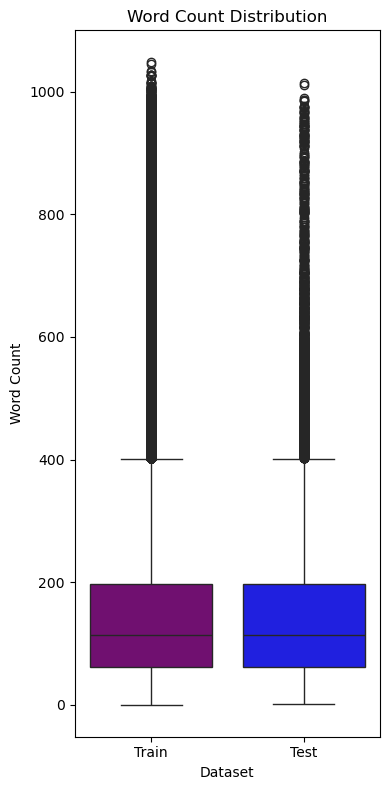

In [42]:
# Word count outliers - Train and test in one plot
plt.figure(figsize=(4, 8))

# Create a DataFrame to use with seaborn's boxplot
combined_data = pd.DataFrame({
    'Word Count': pd.concat([train['word_count'], test['word_count']]),
    'Dataset': ['Train'] * len(train) + ['Test'] * len(test)
})

# Create boxplot with dataset on x-axis
sns.boxplot(x='Dataset', 
            y='Word Count', 
            hue='Dataset', 
            data=combined_data, 
            palette={'Train': 'purple', 'Test': 'blue'}, 
            legend=False)

plt.title('Word Count Distribution')
plt.ylabel('Word Count')
plt.tight_layout()

plt.show()

In [43]:
# Max word count is 10th percentile, Min is 90th percentile
train['word_count'].quantile(0.1), train['word_count'].quantile(0.9)

(32.0, 315.0)

In [44]:
# Filter out if word count is less than 10th percentile and greater than 90th percentile. Too short to be constructive enough to generate insights from.
train = train[(train['word_count'] >= train['word_count'].quantile(0.1)) & (train['word_count'] <= train['word_count'].quantile(0.9))]
test = test[(test['word_count'] >= test['word_count'].quantile(0.1)) & (test['word_count'] <= test['word_count'].quantile(0.9))]

print(train.shape, test.shape)

(313592, 4) (24013, 4)


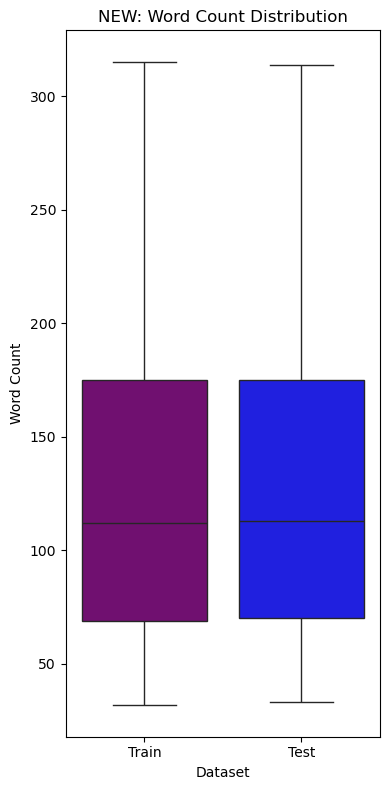

In [45]:
# Word count outliers - Train and test in one plot
plt.figure(figsize=(4, 8))

# Create a DataFrame to use with seaborn's boxplot
combined_data = pd.DataFrame({
    'Word Count': pd.concat([train['word_count'], test['word_count']]),
    'Dataset': ['Train'] * len(train) + ['Test'] * len(test)
})

# Create boxplot with dataset on x-axis
sns.boxplot(x='Dataset', 
            y='Word Count', 
            hue='Dataset', 
            data=combined_data, 
            palette={'Train': 'purple', 'Test': 'blue'}, 
            legend=False)

plt.title('NEW: Word Count Distribution')
plt.ylabel('Word Count')
plt.tight_layout()

plt.show()

In [46]:
# Check class distribution
print(train['label'].value_counts(normalize=True),'\n')
print(test['label'].value_counts(normalize=True))

label
3    0.338991
2    0.336817
1    0.324192
Name: proportion, dtype: float64 

label
3    0.338109
2    0.337859
1    0.324033
Name: proportion, dtype: float64


In [47]:
display(train.head()), display(test.head())

,label,text,clean_text,word_count
1,2,"Unfortunately, the frustration of being Dr. Go...","unfortunately, the frustration of being dr. go...",114
4,1,I don't know what Dr. Goldberg was like before...,i don't know what dr. goldberg was like before...,212
7,1,I'm writing this review to give you a heads up...,i'm writing this review to give you a heads up...,194
8,2,Wing sauce is like water. Pretty much a lot of...,wing sauce is like water. pretty much a lot of...,62
9,3,Decent range somewhat close to the city. The ...,decent range somewhat close to the city. the m...,85


,label,text,clean_text,word_count
0,1,I got 'new' tires from them and within two wee...,i got 'new' tires from them and within two wee...,152
1,1,Don't waste your time. We had two different p...,don't waste your time. we had two different pe...,40
2,1,All I can say is the worst! We were the only 2...,all i can say is the worst! we were the only 2...,185
3,1,I have been to this restaurant twice and was d...,i have been to this restaurant twice and was d...,223
4,1,Food was NOT GOOD at all! My husband & I ate h...,food was not good at all! my husband i ate her...,160


(None, None)

### Splitting...

In [52]:
train.shape, test.shape # I'm splitting the data into 3 parts, It helps with computing, and this way, I can finetune phi-2 on an as-needed basis. I guess I have to do this for the test set as well.

((313592, 4), (24013, 4))

In [54]:
from sklearn.model_selection import StratifiedKFold

# Multiple stratified samples of specified sizes from train and test datasets.
def create_balanced_samples(train_df, test_df, label_column, train_sizes=[10000, 5000], test_sizes=[2000, 1000]):
    """
    Creates multiple perfectly balanced samples from train and test datasets.
    Each class/label will have exactly the same number of samples.
    
    Args:
        train_df: Training dataframe
        test_df: Testing dataframe
        label_column: Column name for stratification
        train_sizes: List of sample sizes for training data
        test_sizes: List of sample sizes for testing data
        
    Returns:
        List of training samples and list of test samples
    """
    train_samples = []
    test_samples = []
    
    # Get unique labels
    train_labels = train_df[label_column].unique()
    test_labels = test_df[label_column].unique()
    
    # Create training samples
    for size in train_sizes:
        samples_per_class = size // len(train_labels)
        balanced_sample = pd.DataFrame()
        
        for label in train_labels:
            class_data = train_df[train_df[label_column] == label]
            if len(class_data) < samples_per_class:
                print(f"Warning: Not enough samples for label {label} in training data. Using all {len(class_data)} samples.")
                sampled_class = class_data
            else:
                sampled_class = class_data.sample(samples_per_class, random_state=12)
            
            balanced_sample = pd.concat([balanced_sample, sampled_class])
        
        train_samples.append(balanced_sample)
    
    # Create test samples
    for size in test_sizes:
        samples_per_class = size // len(test_labels)
        balanced_sample = pd.DataFrame()
        
        for label in test_labels:
            class_data = test_df[test_df[label_column] == label]
            if len(class_data) < samples_per_class:
                print(f"Warning: Not enough samples for label {label} in test data. Using all {len(class_data)} samples.")
                sampled_class = class_data
            else:
                sampled_class = class_data.sample(samples_per_class, random_state=12)
            
            balanced_sample = pd.concat([balanced_sample, sampled_class])
        
        test_samples.append(balanced_sample)
    
    return train_samples, test_samples

# Use
train_samples, test_samples = create_balanced_samples(
    train, 
    test, 
    label_column='label', 
    train_sizes=[10000, 5000], 
    test_sizes=[2000, 1000]
)

# Samples
train_10k = train_samples[0]
train_5k = train_samples[1]
test_2k = test_samples[0]
test_1k = test_samples[1]

In [55]:
# Verify sizes and distributions
for i, sample in enumerate(train_samples):
    print(f"Train sample {i+1} shape: {sample.shape}")
    print(f"Label distribution: {sample['label'].value_counts(normalize=True)}")

print("\n")

for i, sample in enumerate(test_samples):
    print(f"Test sample {i+1} shape: {sample.shape}")
    print(f"Label distribution: {sample['label'].value_counts(normalize=True)}")

Train sample 1 shape: (9999, 4)
Label distribution: label
2    0.333333
1    0.333333
3    0.333333
Name: proportion, dtype: float64
Train sample 2 shape: (4998, 4)
Label distribution: label
2    0.333333
1    0.333333
3    0.333333
Name: proportion, dtype: float64


Test sample 1 shape: (1998, 4)
Label distribution: label
1    0.333333
3    0.333333
2    0.333333
Name: proportion, dtype: float64
Test sample 2 shape: (999, 4)
Label distribution: label
1    0.333333
3    0.333333
2    0.333333
Name: proportion, dtype: float64


### Saving

In [56]:
# Create the directory if it doesn't exist
save_here = "../data/for_step_1/"
if not os.path.exists(save_here):
    os.makedirs(save_here)

In [57]:
train_dfs = [train_10k, train_5k]
test_dfs = [test_2k, test_1k]

# Save the splits
for i, df in enumerate(train_dfs):
    df.to_csv(save_here + f'train_samples_{i+1}.csv', index=False)
    if save_here + f'train_samples_{i+1}.csv':
        print(f"File train_samples_{i+1}.csv saved successfully!")

print("\n\n")
        
for i, df in enumerate(test_dfs):
    df.to_csv(save_here + f'test_samples_{i+1}.csv', index=False)
    if save_here + f'test_samples_{i+1}.csv':
        print(f"File test_samples_{i+1}.csv saved successfully!")

File train_samples_1.csv saved successfully!
File train_samples_2.csv saved successfully!



File test_samples_1.csv saved successfully!
File test_samples_2.csv saved successfully!


# Step 1

In [58]:
# Create the directory if it doesn't exist
save_here = "../data/for_step_1/"
if not os.path.exists(save_here):
    os.makedirs(save_here)

# Load train and test data
train10k = pd.read_csv(save_here + 'train_samples_1.csv')
train5k = pd.read_csv(save_here + 'train_samples_2.csv')

test2k = pd.read_csv(save_here + 'test_samples_1.csv')
test1k = pd.read_csv(save_here + 'test_samples_2.csv')

print('Train:', train10k.shape, train5k.shape)
print('Test:', test2k.shape, test1k.shape)

Train: (9999, 4) (4998, 4)
Test: (1998, 4) (999, 4)


#### Initializing the Model

In [59]:
# Imports
import time
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [60]:
# Clear CUDA cache
torch.cuda.empty_cache()

In [61]:
# Load SamLowe's GoEmotions model
model_name = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [62]:
# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # I did install cuda for this
model.to(device) 
model.eval()  # Set to evaluation mode

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

#### Tokenize

In [63]:
# Print the current GPU being used
current_device = torch.cuda.current_device()
print(f"Using GPU: {current_device} - {torch.cuda.get_device_name(current_device)}")

print(f"PyTorch version: {torch.__version__}")
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Check your installation.")

# Print GPU memory usage
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e6:.2f} MB")
print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e6:.2f} MB")

Using GPU: 0 - NVIDIA GeForce RTX 3060
PyTorch version: 2.5.1+cu121
CUDA Available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3060
GPU memory allocated: 499.97 MB
GPU memory cached: 555.75 MB


In [64]:
# Tokenize the text
def tokenize_text(text):
    return tokenizer(text, 
                     padding="max_length", 
                     truncation=True, 
                     max_length=64,
                     return_tensors="pt")

# Example check
example = train10k['clean_text'].iloc[0]
tokenized_example = tokenize_text(example)

print("Original Text:", example)
print("Tokenized Output:", tokenized_example)

Original Text: the cashier told my husband that should he get change and the air machine just don't work don't come back in asking for a refund. this location the employees are uneducated on any kind of hospitality when having contact with human customers. i just don't care for employees who have a rude attitude. how do store owners proudly have a rude person as a cashier? well let's see how that will work out for them. attention all friends the people are rude at this location.
Tokenized Output: {'input_ids': tensor([[    0,   627,  1055,   906,   174,   127,  1623,    14,   197,    37,
           120,   464,     8,     5,   935,  3563,    95,   218,    75,   173,
           218,    75,   283,   124,    11,  1996,    13,    10, 12173,     4,
            42,  2259,     5,  1321,    32,   542, 26414,    15,   143,   761,
             9, 13779,    77,   519,  1511,    19,  1050,   916,     4,   939,
            95,   218,    75,   575,    13,  1321,    54,    33,    10, 21820,
          

In [65]:
# Load label names
emotion_labels = ["admiration", "amusement", "anger", "annoyance",
                  "approval", "caring", "confusion", "curiosity", 
                  "desire", "disappointment", "disapproval", "disgust",
                  "embarrassment", "excitement", "fear", "gratitude",
                  "grief", "joy", "love", "nervousness", "optimism",
                  "pride", "realization", "relief", "remorse",
                  "sadness", "surprise", "neutral"]

In [66]:
# Function to get top 3 emotions
def get_emotion_label(text):
    # Tokenize text
    tokens = tokenizer(text,
                       padding=True,
                       truncation=True,
                       max_length=128,
                       return_tensors="pt").to(model.device)

    # Run inference
    with torch.no_grad():
        outputs = model(**tokens)

    # Get top 3 predicted labels
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)  # Convert logits to probabilities
    top3_indices = torch.argsort(probabilities, descending=True)[0][:3]  # Get top 3 indices
    
    # Convert indices to emotion labels
    top3_emotions = [emotion_labels[i] for i in top3_indices]
    
    # Return as string...
    return ", ".join(top3_emotions)

In [67]:
# Testing
print(get_emotion_label(train10k['clean_text'][0]))
print(train10k['clean_text'][0])

annoyance, anger, neutral
the cashier told my husband that should he get change and the air machine just don't work don't come back in asking for a refund. this location the employees are uneducated on any kind of hospitality when having contact with human customers. i just don't care for employees who have a rude attitude. how do store owners proudly have a rude person as a cashier? well let's see how that will work out for them. attention all friends the people are rude at this location.


### Running the full inference...

In [68]:
# Loop through the train1 data
for i, row in train10k.iterrows():
  train10k.at[i, "emotions"] = get_emotion_label(row["clean_text"])

display(train10k.head())

,label,text,clean_text,word_count,emotions
0,2,The cashier told my husband that should he get...,the cashier told my husband that should he get...,85,"annoyance, anger, neutral"
1,2,Here's what happened:\n- We were suppose to be...,here's what happened n we were suppose to be a...,297,"realization, neutral, disappointment"
2,2,Went to this Fest today and admission is $12. ...,went to this fest today and admission is 12. t...,197,"neutral, disapproval, approval"
3,2,went to check out this joint the other weekend...,went to check out this joint the other weekend...,82,"admiration, approval, neutral"
4,2,A whole lot of meh. This store is in a horribl...,a whole lot of meh. this store is in a horribl...,34,"disappointment, sadness, fear"


In [69]:
# Loop through the train2 data
for i, row in train5k.iterrows():
  train5k.at[i, "emotions"] = get_emotion_label(row["clean_text"])

display(train5k.head())

,label,text,clean_text,word_count,emotions
0,2,The cashier told my husband that should he get...,the cashier told my husband that should he get...,85,"annoyance, anger, neutral"
1,2,Here's what happened:\n- We were suppose to be...,here's what happened n we were suppose to be a...,297,"realization, neutral, disappointment"
2,2,Went to this Fest today and admission is $12. ...,went to this fest today and admission is 12. t...,197,"neutral, disapproval, approval"
3,2,went to check out this joint the other weekend...,went to check out this joint the other weekend...,82,"admiration, approval, neutral"
4,2,A whole lot of meh. This store is in a horribl...,a whole lot of meh. this store is in a horribl...,34,"disappointment, sadness, fear"


In [70]:
# Loop through the test1 data
for i, row in test2k.iterrows():
  test2k.at[i, "emotions"] = get_emotion_label(row["clean_text"])
  
display(test2k.head())

,label,text,clean_text,word_count,emotions
0,1,Although I also REALLY enjoy Mi Familia (just ...,although i also really enjoy mi familia just d...,242,"joy, admiration, optimism"
1,1,"So in all fairness, the course was actually ve...","so in all fairness, the course was actually ve...",183,"annoyance, neutral, disappointment"
2,1,I tried to go here last night; party of five. ...,i tried to go here last night party of five. t...,67,"joy, admiration, approval"
3,1,Service was super slow and the food was terrib...,service was super slow and the food was terrib...,75,"disappointment, disapproval, annoyance"
4,1,"The 8\"" pizzas were fully cooked but the 14\"" ...",the 8 pizzas were fully cooked but the 14 and ...,84,"amusement, neutral, joy"


In [71]:
# Loop through the test2 data
for i, row in test1k.iterrows():
  test1k.at[i, "emotions"] = get_emotion_label(row["clean_text"])
  
display(test1k.head())

,label,text,clean_text,word_count,emotions
0,1,Although I also REALLY enjoy Mi Familia (just ...,although i also really enjoy mi familia just d...,242,"joy, admiration, optimism"
1,1,"So in all fairness, the course was actually ve...","so in all fairness, the course was actually ve...",183,"annoyance, neutral, disappointment"
2,1,I tried to go here last night; party of five. ...,i tried to go here last night party of five. t...,67,"joy, admiration, approval"
3,1,Service was super slow and the food was terrib...,service was super slow and the food was terrib...,75,"disappointment, disapproval, annoyance"
4,1,"The 8\"" pizzas were fully cooked but the 14\"" ...",the 8 pizzas were fully cooked but the 14 and ...,84,"amusement, neutral, joy"


In [72]:
print('Train:', train10k.shape, train5k.shape)
print('Test:', test2k.shape, test1k.shape)

Train: (9999, 5) (4998, 5)
Test: (1998, 5) (999, 5)


#### Saving

In [79]:
# Create the directory if it doesn't exist
save_here = "../data/for_step_2/"
if not os.path.exists(save_here):
    os.makedirs(save_here)

In [80]:
train_dfs = [train10k, train5k]
test_dfs = [test2k, test1k]

# Save the splits
for i, df in enumerate(train_dfs):
    df.to_csv(save_here + f'train_samples_{i+1}.csv', index=False)
    if save_here + f'train_samples_{i+1}.csv':
        print(f"File train_samples_{i+1}.csv saved successfully!")

print("\n\n")
        
for i, df in enumerate(test_dfs):
    df.to_csv(save_here + f'test_samples_{i+1}.csv', index=False)
    if save_here + f'test_samples_{i+1}.csv':
        print(f"File test_samples_{i+1}.csv saved successfully!")

File train_samples_1.csv saved successfully!
File train_samples_2.csv saved successfully!



File test_samples_1.csv saved successfully!
File test_samples_2.csv saved successfully!


In [81]:
# pytorch version, cuda version, and the GPU being used
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.5.1+cu121
